# Descriptive Statistics Review

In this second part of the lab, we are going to continue working with the data that we cleaned in the last part. 
Be sure to continue to write clean code and comment your work well!

First, lets import our libraries and the data we saved. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.preprocessing import StandardScaler, scale
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split

from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

## Import file, dropping non-ordinal colums

In [2]:
diamonds = pd.read_csv('diamonds_data.csv')

In [3]:
diamonds = pd.read_csv('diamonds_data.csv')
diamonds = diamonds.loc[:, diamonds.dtypes == 'float64']

Diamonds = diamonds.loc[:, diamonds.columns != 'price']
diamonds_price = diamonds['price']

# Do the regression

## Train test splitting

In [15]:
Diamonds_train, Diamonds_test, diamonds_price_train, diamonds_price_test = \
    train_test_split(
        Diamonds, diamonds_price
    )

## Model

In [10]:
columns = ['carat', 'depth', 'table', 'clarity_idx', 'color_idx', 'cut_idx', 'pca_x_y_z']

def add_level(lst = [], i = 0, l = 0):
    if l == len(columns):
        return lst

    if l == 0:
        lst = [[columns[0]]]
        lst = add_level(lst, i, l + 1)
    else:
        curr_idx = len(lst)

        for j in range(l, len(columns)):
            if columns.index(lst[i][-1]) < j:
                lst.append(lst[i] + [columns[j]])

        for j in range(curr_idx, len(lst)):
            lst = add_level(lst, j, l + 1)
        
    return lst

tries = \
    pd.DataFrame(
        index = [', '.join(c) for c in add_level()],
        columns = ['MSE', 'R2']
    )

In [12]:
for idx in tries.index:
    columns = idx.split(', ')
    
    model = LinearRegression()
    model.fit(Diamonds_train[columns], diamonds_price_train)
    
    data = Diamonds_test[columns]    
    price_predicted = model.predict(data)
    
    tries.loc[idx]['MSE'] = np.sqrt(mean_squared_error(diamonds_price_test, price_predicted))
    tries.loc[idx]['R2']  = r2_score(diamonds_price_test, price_predicted)

In [13]:
tries.sort_values(by='R2', ascending=False).head()

,MSE,R2
"carat, depth, table, clarity_idx, color_idx, cut_idx, pca_x_y_z",1144.58,0.916537
"carat, depth, clarity_idx, color_idx, cut_idx, pca_x_y_z",1146.19,0.916302
"carat, depth, table, clarity_idx, color_idx, pca_x_y_z",1148.25,0.916001
"carat, table, clarity_idx, color_idx, cut_idx, pca_x_y_z",1149.13,0.915872
"carat, clarity_idx, color_idx, cut_idx, pca_x_y_z",1149.25,0.915855


In [14]:
tries.sort_values(by='MSE', ascending=True).head()

,MSE,R2
"carat, depth, table, clarity_idx, color_idx, cut_idx, pca_x_y_z",1144.58,0.916537
"carat, depth, clarity_idx, color_idx, cut_idx, pca_x_y_z",1146.19,0.916302
"carat, depth, table, clarity_idx, color_idx, pca_x_y_z",1148.25,0.916001
"carat, table, clarity_idx, color_idx, cut_idx, pca_x_y_z",1149.13,0.915872
"carat, clarity_idx, color_idx, cut_idx, pca_x_y_z",1149.25,0.915855


# Do the regression based on Clarity

In [105]:
model_columns = ['carat', 'x', 'y']

In [106]:
diamonds_clarity_split = {}

for clarity in diamonds.clarity_idx.unique():
    data   = diamonds[diamonds.clarity_idx == clarity]
    #
    featrs = data.loc[:, diamonds.columns != 'price']
    prices = data['price']    
    
    Train, Test, train, test = train_test_split(featrs, prices)
        
    diamonds_clarity_split[clarity] = \
        {
            'data': data,
            #
            'Train': Train, 'Test': Test,
            'train': train, 'test': test
        }

In [143]:
split_result   = []
split_expected = []

for clarity in diamonds.clarity_idx.unique():
    split = diamonds_clarity_split[clarity]
    #
    split_Train = split['Train'][model_columns]
    split_train = split['train']
    #
    split_Test = split['Test'][model_columns]
    split_test = split['test']
    
    model = LinearRegression()
    model.fit(split_Train, split_train)
    
    price_predicted = model.predict(split_Test)
    
    split_result.extend(price_predicted)
    split_expected.extend(split_test)

1123.352560220326
0.9165112015283639


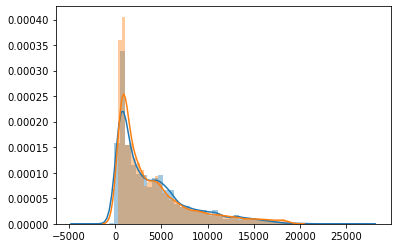

In [144]:
print(np.sqrt(mean_squared_error(split_result, split_expected)))
print(r2_score(split_result, split_expected))

sns.distplot(split_result, )
sns.distplot(split_expected)

# Apply!

In [193]:
rick = pd.read_csv('rick_diamonds.csv')

## Qualify

In [194]:
clarities = ['I1', 'SI2', 'SI1', 'VS2', 'VS1', 'VVS2', 'VVS1', 'IF']

rick['clarity_idx'] = [clarities.index(c) for c in rick.clarity]

In [195]:
colors = ['J', 'I', 'H', 'G', 'F', 'E', 'D']

rick['color_idx'] = [colors.index(c) for c in rick.color]

In [196]:
cuts = ['Fair', 'Good', 'Very Good', 'Premium', 'Ideal']

rick['cut_idx'] = [cuts.index(c) for c in rick.cut]

## PCA for x, y, z

In [197]:
pca_data = rick[['x', 'y', 'z']]

pca_x_y_z = PCA(n_components=1)
pca_x_y_z.fit(pca_data)

rick['pca_x_y_z'] = pca_x_y_z.transform(rick[['x', 'y', 'z']])
pca_x_y_z.explained_variance_ratio_

array([0.99526299])

## Run model

In [203]:
rick['price_predicted'] = np.nan

for clarity in diamonds.clarity_idx.unique():
    data      = diamonds[diamonds.clarity_idx == clarity]
    rick_data = rick[rick.clarity_idx == clarity]
    
    model = LinearRegression()
    model.fit(data[model_columns], data.price)
    
    rick.loc[rick_data.index, ['price_predicted']]=model.predict(rick_data[model_columns])

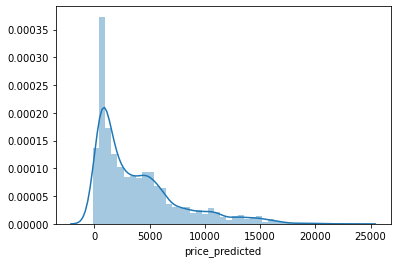

In [207]:
sns.distplot(rick['price_predicted'])

## Output

In [208]:
rick.to_csv('diamonds_rick.csv', index=False)